In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="base", id="xpump2-pump_disabled", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="pump", id="xpump4-pump_with_frec", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.607E+00 [m3]


## Check recycling

In [4]:
ds = casestore["pump"].ds

In [ ]:
edge

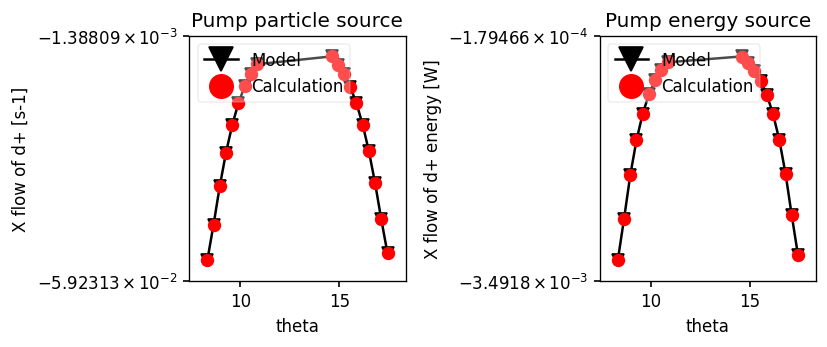

In [37]:
sol_multiplier = 1.0
sol_fast_recycle_energy_factor = 0.0
sol_fast_recycle_fraction = 0.0
sol_energy = 3 * q_e
pump_multiplier = 0.94

m = ds.metadata
# q_e = constants("q_e")
# Mi = constants("mass_p") * 2

i = -3
g = -2
s = -4

Td = ds["Td"].values / m["Tnorm"]
Nd = ds["Nd"].values / m["Nnorm"]
dl = ds["dl"] / m["rho_s0"]
dtor = ds["dtor"] / m["rho_s0"]
dv = ds["dv"] / (m["rho_s0"]**3)
ion_particle_flow = (ds["ParticleFlow_d+_xlow"].isel(x=-2)) / ds["ParticleFlow_d+_xlow"].attrs["conversion"]
ion_heat_flow = (ds["EnergyFlow_d+_xlow"].isel(x=-2)) / ds["ParticleFlow_d+_xlow"].attrs["conversion"]

Mi = 2
q_e = 1


### Recycling
# Particles
recycle_particle_flow = ion_particle_flow * sol_multiplier

# Heat
fast_bit = ion_heat_flow * sol_multiplier * sol_fast_recycle_fraction * sol_fast_recycle_energy_factor 
thermal_bit = ion_particle_flow * sol_multiplier * (1-sol_fast_recycle_fraction) * sol_energy
recycle_heat_flow = fast_bit + thermal_bit

### Neutral impingement
tnguard = Td[i]**2 / Td[s] 
nnguard = Nd[i]**2 / Nd[s] 
nnsheath = 0.5 * (Nd[i] + nnguard)
tnsheath = 0.5 * (Td[i] + tnguard)
v_th = 0.25 * np.sqrt(8 * tnsheath * q_e / (np.pi * Mi))

dtorsheath = 0.5*(dtor[i] + dtor[g])
dlsheath = 0.5*(dl[i] + dl[g])
dasheath = dtorsheath * dlsheath

pump_neutral_particle_flow = v_th * nnsheath * dasheath
pump_neutral_particle_sink = pump_neutral_particle_flow / dv[i] * (1-pump_multiplier)

pump_neutral_energy_flow = 2.0 * tnsheath * v_th * nnsheath * dasheath 
pump_neutral_energy_sink = pump_neutral_energy_flow / dv[i] * (1-pump_multiplier)

### Totals
pump_density_source = recycle_particle_flow/dv - pump_neutral_particle_sink
pump_energy_source = recycle_heat_flow/dv - pump_neutral_energy_sink

norm = m["Nnorm"] * m["Omega_ci"]

edge = ds.isel(x=-3)
pump_theta = edge["theta"].where(edge["is_pump"]==1, drop = True).values

fig, axes = plt.subplots(1,2, figsize=(7,3), dpi = 120)
ax = axes[0]

sim_result = (edge["Sd_pump"] / edge["Sd_pump"].attrs["conversion"]).sel(theta=pump_theta)
calc_result = pump_density_source.isel(x=-3).sel(theta=pump_theta)

(sim_result).plot(ax = ax, label = "Model", marker = "v", ms = 7, c = "k",)
(calc_result).plot(ax = ax, label = "Calculation", marker = "o", lw = 0, ms = 7, c = "red")
ax.set_title("Pump particle source")

ax = axes[1]

sim_result = (edge["Ed_pump"] / edge["Ed_pump"].attrs["conversion"]).sel(theta=pump_theta)
calc_result = pump_energy_source.isel(x=-3).sel(theta=pump_theta)

(sim_result).plot(ax = ax, label = "Model", marker = "v", ms = 7, c = "k",)
(calc_result).plot(ax = ax, label = "Calculation", marker = "o", lw = 0, ms = 7, c = "red")
ax.set_title("Pump energy source")

for ax in axes:
    ax.grid()
    ax.set_yscale("symlog")
    ax.legend(loc = "upper left")

fig.tight_layout()


In [25]:
calc.shape

(58, 20)

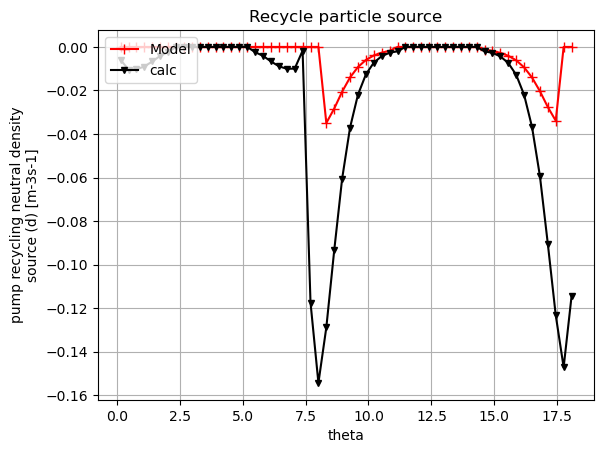

In [10]:

m = ds.metadata
# q_e = constants("q_e")
# Mi = constants("mass_p") * 2

i = 2
g = 1
s = 3

Td = ds["Td"].values / m["Tnorm"]
Nd = ds["Nd"].values / m["Nnorm"]
dl = ds["dl"] / m["rho_s0"]
dtor = ds["dtor"] / m["rho_s0"]
dv = ds["dv"] / (m["rho_s0"]**3)
ionflow = (ds["ParticleFlow_d+_xlow"].isel(x=-2)) / (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])
recycle_source = ionflow[i] / dv[i]
Mi = 2
q_e = 1


tnguard = Td[i]**2 / Td[s] 
nnguard = Nd[i]**2 / Nd[s] 

nnsheath = 0.5 * (Nd[i] + nnguard)
tnsheath = 0.5 * (Td[i] + tnguard)
v_th = np.sqrt(tnsheath * q_e / Mi)

dtorsheath = 0.5*(dtor[i] + dtor[g])
dlsheath = 0.5*(dl[i] + dl[g])
dasheath = dtorsheath * dlsheath

pflow = v_th * nnsheath * dasheath
psink = pflow / dv[i] * (1-0.99)

psource = recycle_source - psink

eflow = 3.5 * tnsheath * v_th * nnsheath * dasheath
esink = eflow / dv[i] * (1-0.99)

norm = m["Nnorm"] * m["Omega_ci"]

calc = psource

(ds["Sd_pump_recycle"].isel(x=-3)/norm).plot(label = "Model", marker = "+", ms = 7, c = "red")

# (ds["Sd_pump_recycle"].isel(x=-3) *  ds["dv"].isel(x=-3)).plot(label = "Model", marker = "+", ms = 7, c = "red")
plt.plot(ds.isel(x=-3)["theta"], calc, marker = "v", ms = 5, c = "k", label = "calc")
# (calc).plot(label = "Calc", lw = 0, marker = "v", ms = 5, c = "black")
plt.legend(loc = "upper left")
plt.title("Recycle particle source")
plt.grid()
# plt.yscale("symlog")
# ds["Sd_target_recycle"].isel(x=-3).plot()

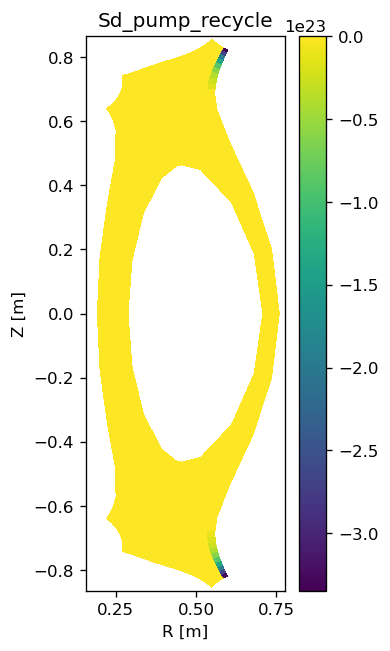

In [11]:
ds["Sd_pump_recycle"].hermesm.clean_guards().bout.polygon()